In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [4]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [7]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/bdt/")

from bdt import *

/data/user/tvaneede/software/py_venvs/py3-v4.4.1_reco-v1.1.0/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/cvmfs/icecube.opensciencegrid.org/py3-v4.4.1/RHEL_7_x86_64_v2/lib/python3.12/pickle.py:1753: UserWarning: [08:16:11] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling


In [8]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["evtgen_v2_rec_v5"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [9]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [10]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/bdt/plots"
os.system(f"mkdir -p {plotting_path}")

0

In [11]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [12]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [13]:
keys_to_merge = {}

keys_to_merge["evtgen_v2_rec_v5"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


In [14]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau


In [15]:
dataset_label_dict = {
    "evtgen_v2_rec_v5" : "ftp-v3",
    "spice_tau_reco" : "spice v3.2.1",
}

check if merging works now, seems to be fine

In [19]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    ConventionalAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    PromptAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

           astro_NuE    astro_NuMu   astro_NuTau            conv       prompt
ftp-v3  56.92 ± 0.55  20.60 ± 0.25  35.03 ± 0.40  25.684 ± 0.991  7.07 ± 0.09


In [44]:
# obtain bdt scores
simulation_dataset_name = "evtgen_v2_rec_v5"

bdt_scores1, bdt_scores2 = {}, {}

for flavor in ["NuE","NuMu", "NuTau","NuAll"]:
    bdt_scores1[flavor], bdt_scores2[flavor] = Append_BDT( simulation_datasets[simulation_dataset_name][flavor]["weighter"] )

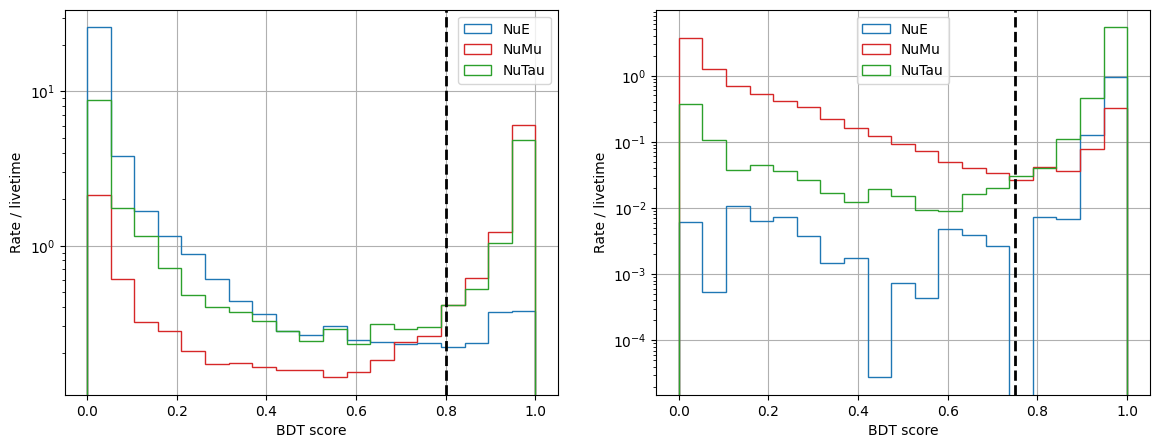

In [52]:
# plot bdt score
simulation_dataset_name = "evtgen_v2_rec_v5"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

bins = np.linspace(0,1,20)
colors = ["C0","C3","C2"]

for i,flavor in enumerate(["NuE","NuMu", "NuTau"]):

    RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")

    mask = RecoETot > 60e3

    # Upper plot: histograms
    ax1.hist(bdt_scores1[flavor][mask], 
             weights=simulation_datasets[simulation_dataset_name][flavor]["weights_astro"][mask], 
             bins=bins, histtype="step", color=colors[i], linestyle="-",label = flavor)

    mask &= bdt_scores1[flavor] > 0.8

    # Upper plot: histograms
    ax2.hist(bdt_scores2[flavor][mask], 
             weights=simulation_datasets[simulation_dataset_name][flavor]["weights_astro"][mask], 
             bins=bins, histtype="step", color=colors[i], linestyle="-",label = flavor)

ax1.set_yscale('log')
ax1.set_ylabel('Rate / livetime')
ax1.set_xlabel('BDT score')
ax1.legend()
ax1.grid(True)
ax1.axvline(x = 0.8,color='black', linestyle='--', linewidth=2)

ax2.set_yscale('log')
ax2.set_ylabel('Rate / livetime')
ax2.set_xlabel('BDT score')
ax2.legend()
ax2.grid(True)
ax2.axvline(x = 0.75,color='black', linestyle='--', linewidth=2)


In [49]:
classifications = {}

classifications["FinalTopology"] = {
    "variables" : ["FinalTopology"],
    "cut_functions" : {
        "Cascade" : lambda vars: vars["FinalTopology"] == 1,            
        "Double"  : lambda vars: vars["FinalTopology"] == 2,           
        "Track"   : lambda vars: vars["FinalTopology"] == 3,
    }
}

classifications["bdt"] = {
    "variables" : ["bdt_scores1", "bdt_scores2"],
    "cut_functions" : {
        "Cascade" : lambda vars:  vars["bdt_scores1"] < 0.8,            
        "Double"  : lambda vars: (vars["bdt_scores1"] > 0.8) & (vars["bdt_scores2"] > 0.75),      
        "Track"   : lambda vars: (vars["bdt_scores1"] > 0.8) & (vars["bdt_scores2"] < 0.75),
    }
}

In [45]:
def analyze_classification_rates_with_cut(
    simulation_dataset, 
    classification, 
    energy_cut_threshold=None
):
    # Assumes the following are defined globally:
    # - AstroFluxModel
    # - generator_conv
    # - generator_pr
    # - livetime_s

    def get_total_rates():
        total = {}
        for flavor in ['NuE', 'NuMu', 'NuTau']:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
            if energy_cut_threshold:
                RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")
                mask = RecoETot > energy_cut_threshold
                weights = weights[mask]
            total[flavor] = np.sum(weights)
        return total

    total_rates = get_total_rates()

    data = {}
    purity = {}
    efficiency = {}

    for ch in classification["cut_functions"]:
        channel_data = {}
        rates = {"total": 0}

        # Conventional + Prompt (NuAll)
        flavor_all = "NuAll"
        ConventionalAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
        PromptAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")            
        RecoETot = simulation_dataset[flavor_all]["weighter"].get_column("RecoETot", "value")

        # Load required variables for this classification
        if "bdt_scores1" in classification["variables"]:
            classification_variables = {
                "bdt_scores1" : bdt_scores1[flavor_all],
                "bdt_scores2" : bdt_scores2[flavor_all]
            }
        else:
            classification_variables = {
                var: simulation_dataset[flavor_all]["weighter"].get_column(var, "value")
                for var in classification["variables"]
            }

        # Apply the cut function, passing the variables dict
        mask = classification["cut_functions"][ch](classification_variables)

        if energy_cut_threshold:
            mask &= RecoETot > energy_cut_threshold

        weights_conv = simulation_dataset[flavor_all]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
        rate_conv = np.sum(weights_conv[mask])
        err_conv = np.sqrt(np.sum(weights_conv[mask]**2))
        channel_data["Conventional"] = f"{rate_conv:.2f} ± {err_conv:.2f}"
        rates["total"] += rate_conv

        weights_prompt = simulation_dataset[flavor_all]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions
        rate_prompt = np.sum(weights_prompt[mask])
        err_prompt = np.sqrt(np.sum(weights_prompt[mask]**2))
        channel_data["Prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"
        rates["total"] += rate_prompt

        # Astro components
        for flavor in ['NuE', 'NuMu', 'NuTau']:
            RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")

            # Load required variables for this classification
            if "bdt_scores1" in classification["variables"]:
                classification_variables = {
                    "bdt_scores1" : bdt_scores1[flavor],
                    "bdt_scores2" : bdt_scores2[flavor]
                }
            else:
                classification_variables = {
                    var: simulation_dataset[flavor]["weighter"].get_column(var, "value")
                    for var in classification["variables"]
                }

            # Apply the cut function, passing the variables dict
            mask = classification["cut_functions"][ch](classification_variables)

            if energy_cut_threshold:
                mask &= RecoETot > energy_cut_threshold

            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
            rate = np.sum(weights[mask])
            err = np.sqrt(np.sum(weights[mask]**2))
            channel_data[f"Astro {flavor}"] = f"{rate:.2f} ± {err:.2f}"
            rates[flavor] = rate
            rates["total"] += rate

        data[ch] = channel_data

        # Purity and Efficiency
        purity[ch] = {
            f: f"{rates[f]/rates['total']:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
        }
        efficiency[ch] = {
            f: f"{rates[f]/total_rates[f]:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
        }

    # Build DataFrames
    df = pd.DataFrame.from_dict(data, orient='index')
    column_order = [f"Astro {f}" for f in ['NuE', 'NuMu', 'NuTau']] + ["Conventional", "Prompt"]
    df = df[column_order]

    purity_df = pd.DataFrame(purity).T.round(4)
    purity_df.columns = ['NuE', 'NuMu', 'NuTau']
    purity_df.index.name = "Class"

    efficiency_df = pd.DataFrame(efficiency).T.round(4)
    efficiency_df.columns = ['NuE', 'NuMu', 'NuTau']
    efficiency_df.index.name = "Class"

    print("\n=== Rates ===\n")
    print(df.to_string())

    print("\n=== Purity ===\n")
    print(purity_df)

    print("\n=== Efficiency ===\n")
    print(efficiency_df)

    print("\n=== Rates ===\n")
    print(df.to_latex(column_format="l" + "c" * len(df.columns), escape=False))

    print("\n=== Purity ===\n")
    print(purity_df.to_latex(column_format="lccc", escape=False))

    print("\n=== Efficiency ===\n")
    print(efficiency_df.to_latex(column_format="lccc", escape=False))

In [53]:
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v2_rec_v5"], classifications["FinalTopology"], 60e3)
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v2_rec_v5"], classifications["bdt"], None)
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v2_rec_v5"], classifications["bdt"], 60e3)


=== Rates ===

            Astro NuE   Astro NuMu   Astro NuTau Conventional       Prompt
Cascade  37.17 ± 0.39  5.66 ± 0.11  17.67 ± 0.24  4.45 ± 0.23  3.41 ± 0.06
Double    0.25 ± 0.03  0.40 ± 0.03   3.70 ± 0.09  0.30 ± 0.06  0.12 ± 0.01
Track     0.57 ± 0.05  7.60 ± 0.12   1.38 ± 0.06  3.75 ± 0.21  0.52 ± 0.02

=== Purity ===

          NuE  NuMu NuTau
Class                    
Cascade  0.54  0.08  0.26
Double   0.05  0.08  0.78
Track    0.04  0.55  0.10

=== Efficiency ===

          NuE  NuMu NuTau
Class                    
Cascade  0.98  0.41  0.78
Double   0.01  0.03  0.16
Track    0.02  0.56  0.06

=== Rates ===

\begin{tabular}{lccccc}
\toprule
 & Astro NuE & Astro NuMu & Astro NuTau & Conventional & Prompt \\
\midrule
Cascade & 37.17 ± 0.39 & 5.66 ± 0.11 & 17.67 ± 0.24 & 4.45 ± 0.23 & 3.41 ± 0.06 \\
Double & 0.25 ± 0.03 & 0.40 ± 0.03 & 3.70 ± 0.09 & 0.30 ± 0.06 & 0.12 ± 0.01 \\
Track & 0.57 ± 0.05 & 7.60 ± 0.12 & 1.38 ± 0.06 & 3.75 ± 0.21 & 0.52 ± 0.02 \\
\bottomrule
\end{ta